# 6/24 SunSpots

In [2]:
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve, decimate
from scipy import interpolate
from sklearn.decomposition import PCA
import sys
import time
sys.path.append("..")
from SlidingWindow import *
from CurvatureTools import *
from Sunspot import *
%matplotlib notebook

<IPython.core.display.Javascript object>


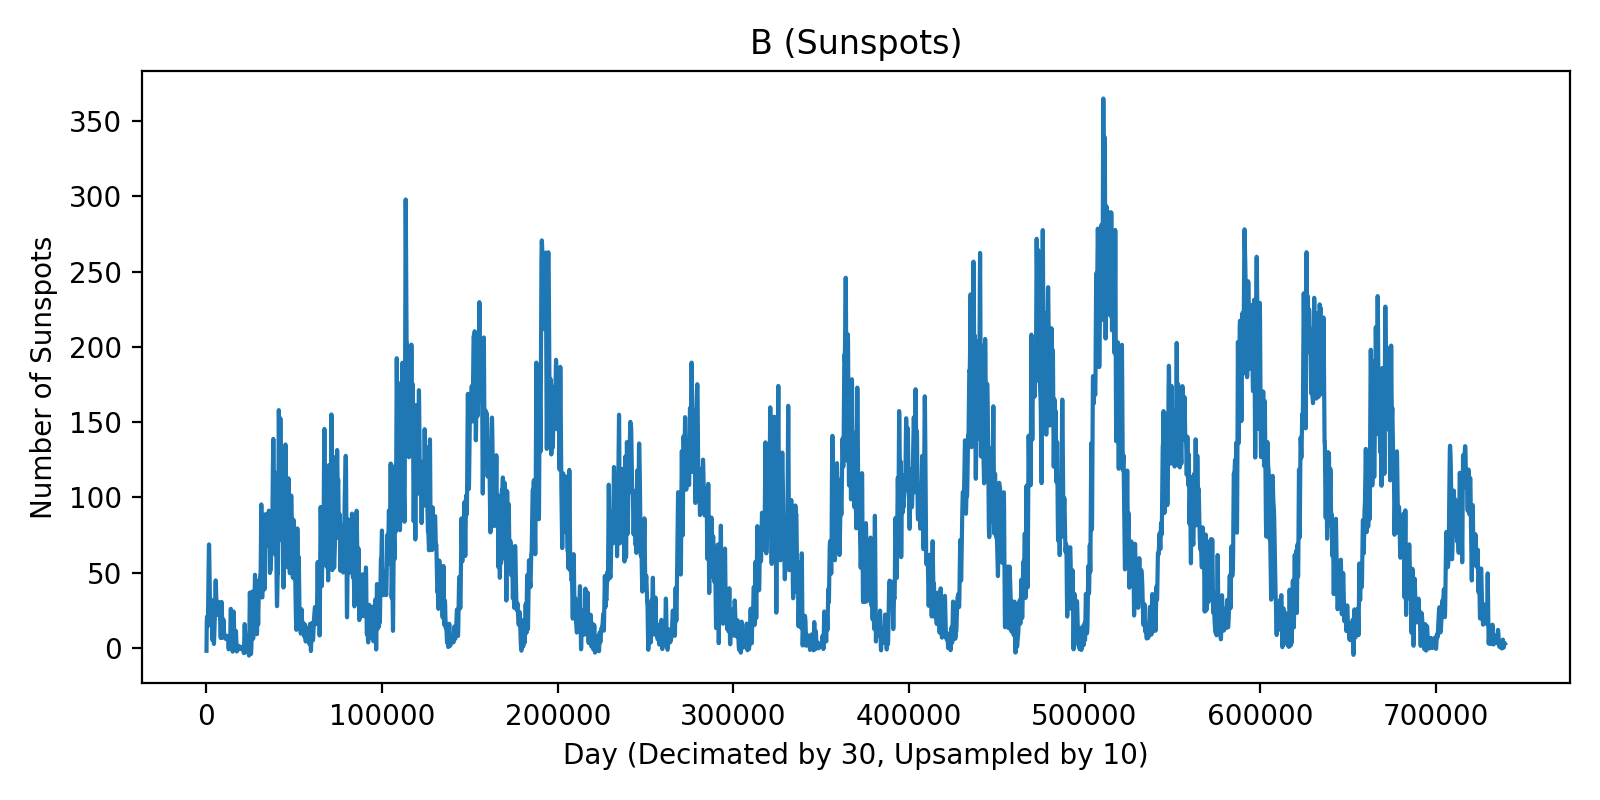

In [5]:
A = extractData()
decfac = 30 # How much I'm decimating (downsampling after smoothing)
fac = 10

decleft = decfac
decdone = 1
while decleft > 1:
    dec = min(decleft, 10)
    A = decimate(A, dec)
    decdone *= dec
    decleft = int(decleft / dec)
A = interpData(A, decdone)
B = interpData(A, fac)

plt.figure(figsize=(8, 4))
plt.plot(B)
plt.ylabel("Number of Sunspots")
plt.xlabel("Day (Decimated by 30, Upsampled by 10)")
plt.title("B (Sunspots)")
plt.tight_layout()

fs = 44100
ipd.Audio(B,rate=fs)

<IPython.core.display.Javascript object>


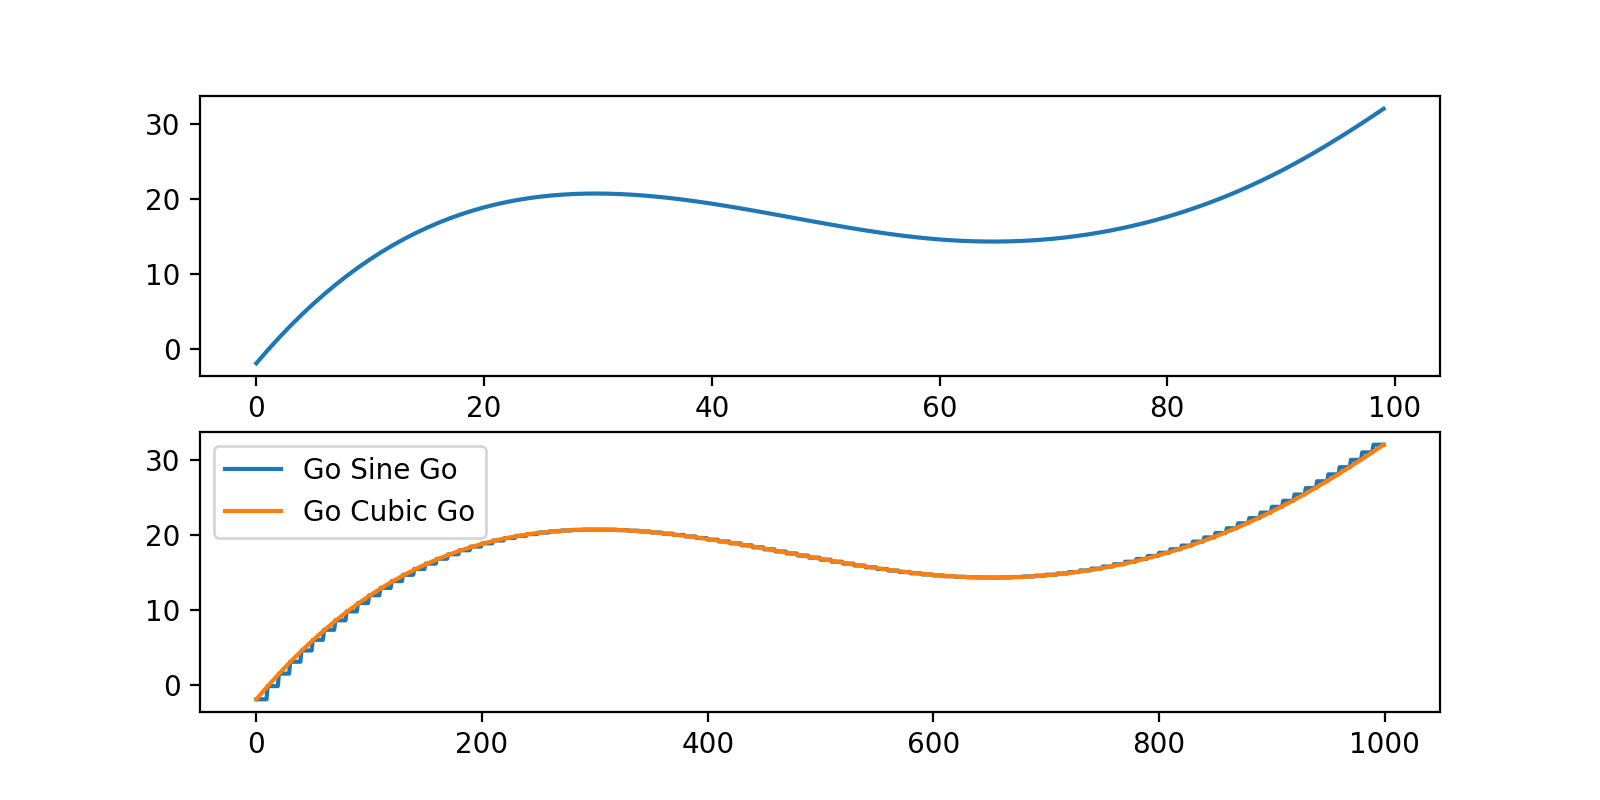

In [3]:
x = A[0:100]
xb = goSinGo(x)
xc = interpData(x, 10)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(x)
plt.subplot(212)
plt.plot(xb)
plt.plot(xc)
plt.legend(["Go Sine Go", "Go Cubic Go"])

# 6/25 Sliding Window & PCA & Log Freq Calc 

Elapsed Time Sliding Window: 0.3301210403442383
Dimension 0: 110.0 - 28160.0


<IPython.core.display.Javascript object>


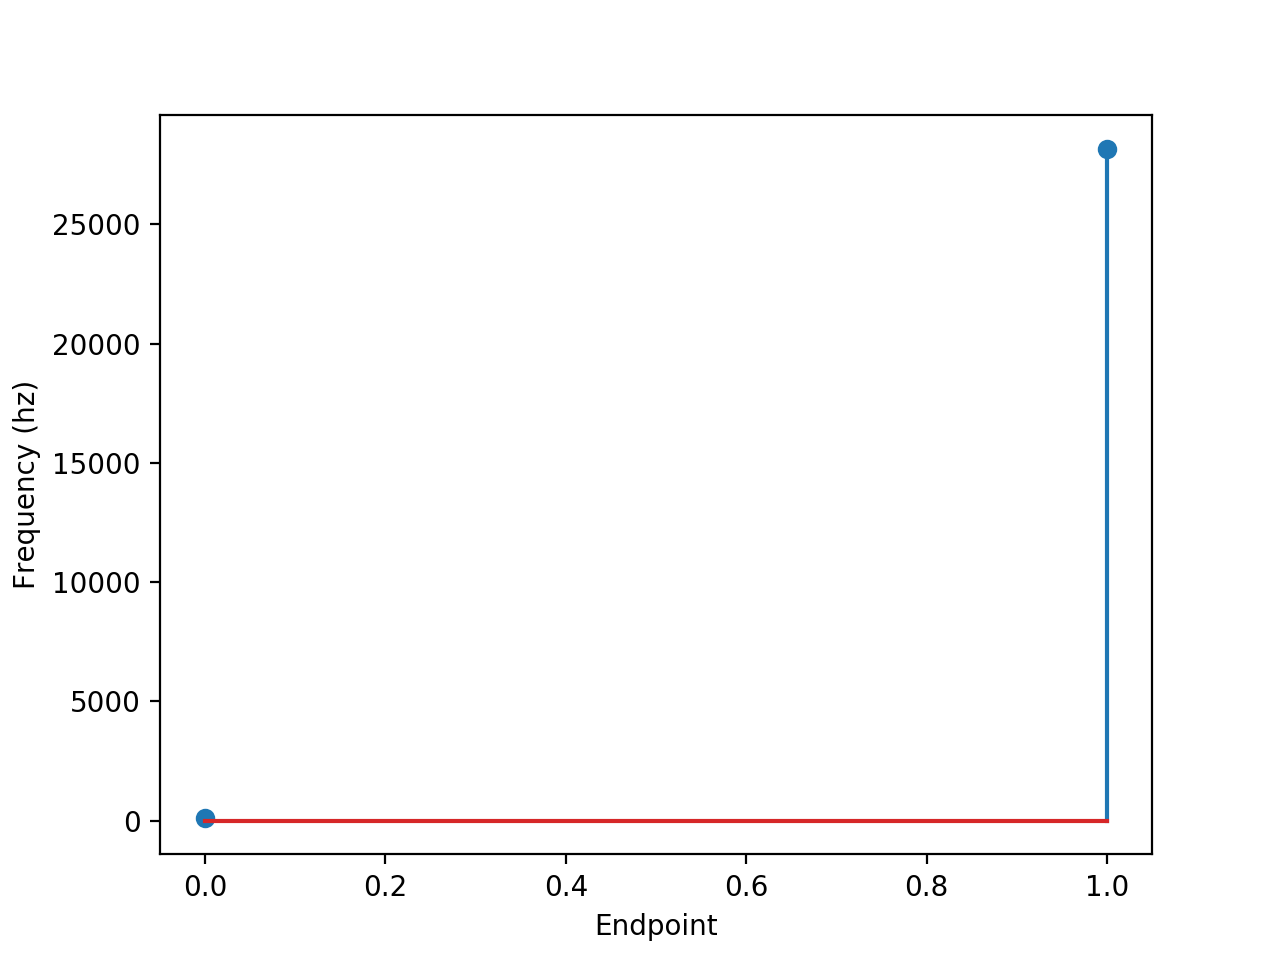

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


<IPython.core.display.Javascript object>


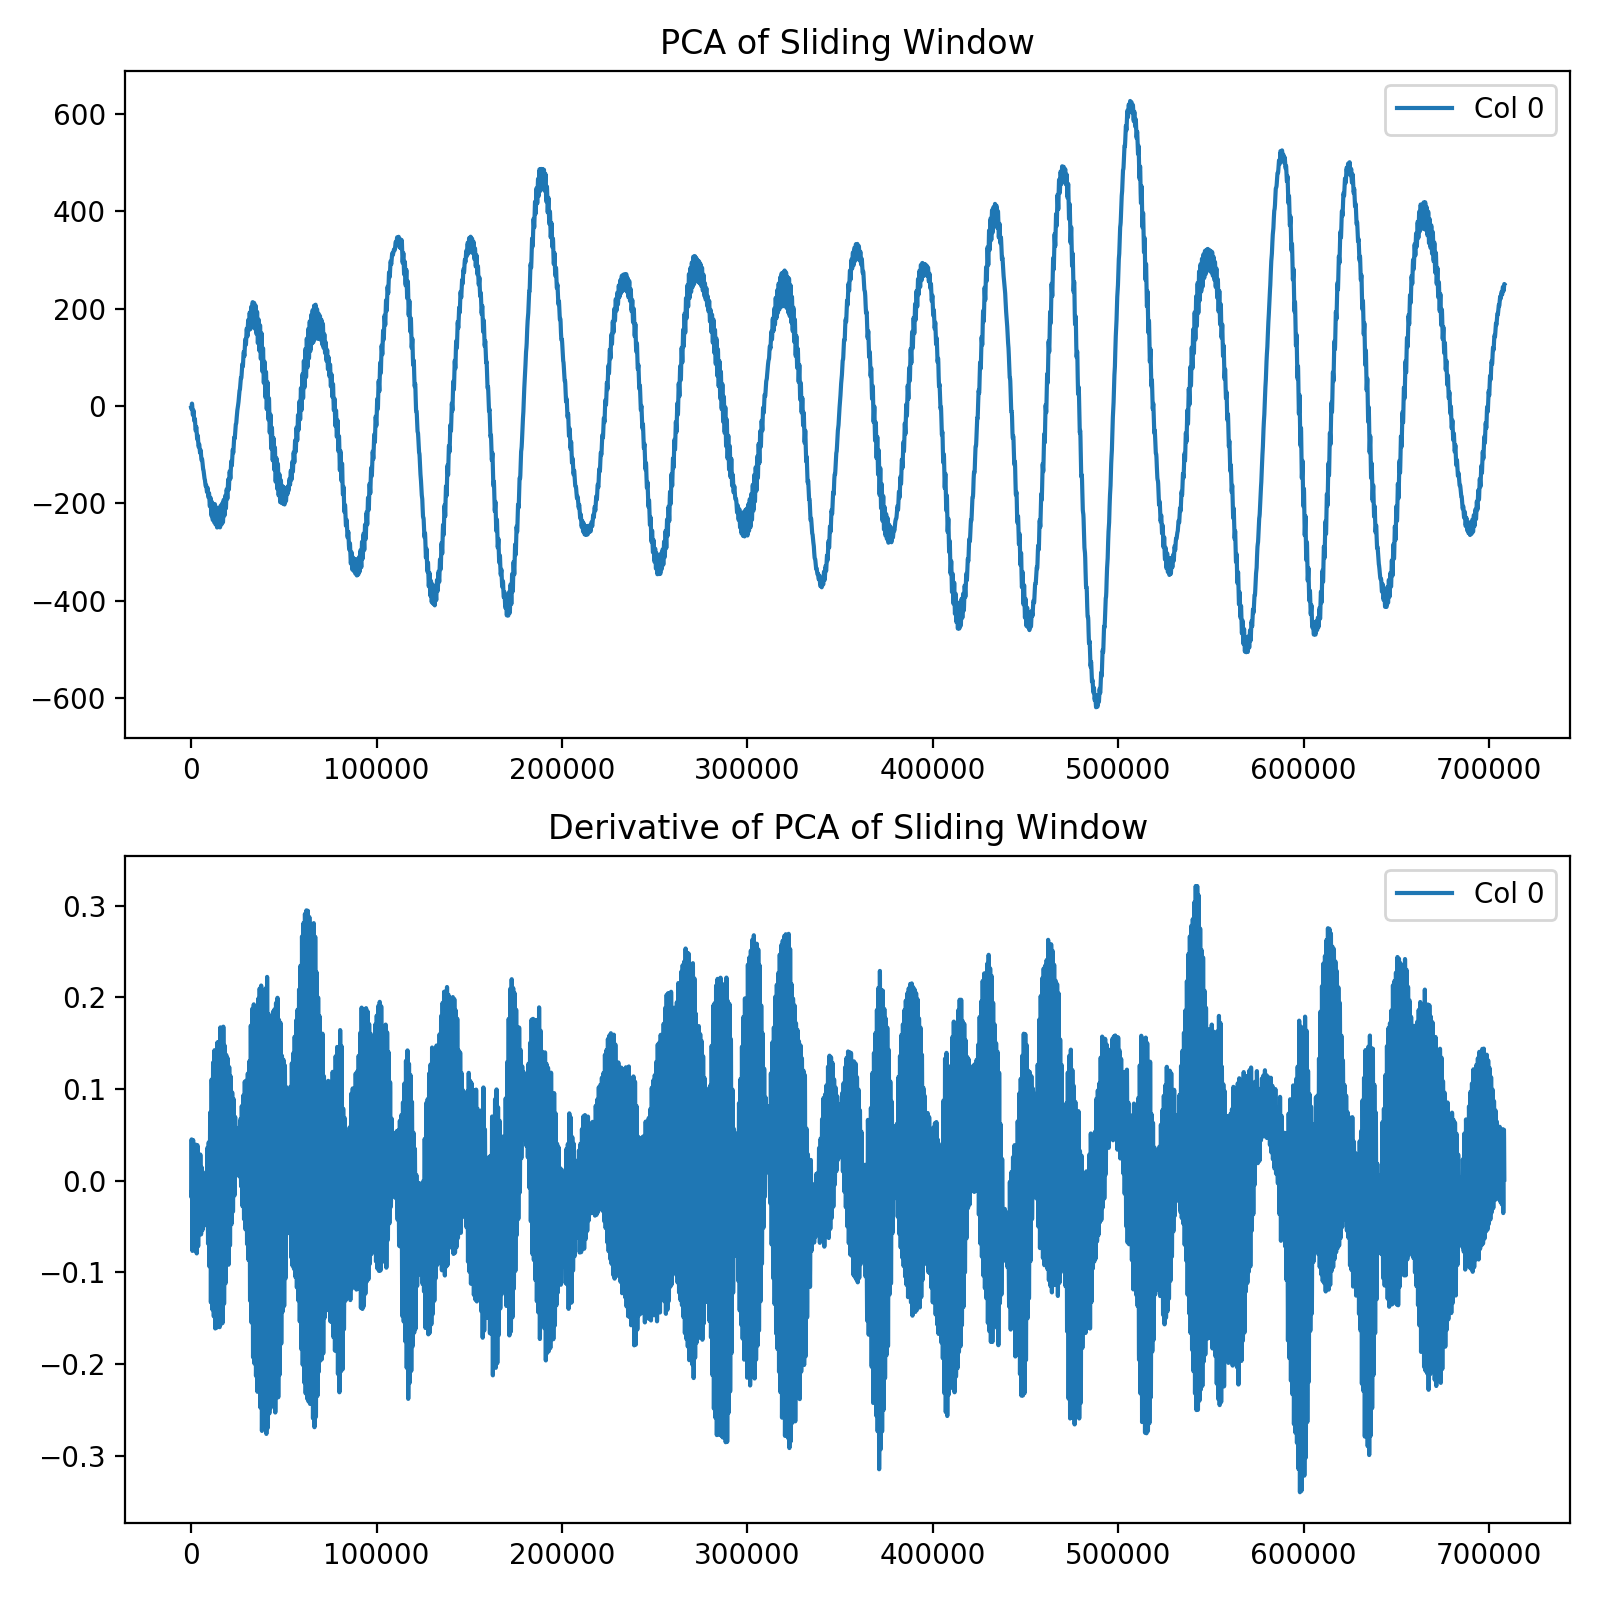

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [5]:
fs = 44100
dim = 40
Tau = 800
dT = 1

tic = time.time()
X = getSlidingWindow(B,dim,Tau,dT)
toc = time.time()
print("Elapsed Time Sliding Window:", toc-tic)

dcom = 1
pca = PCA(n_components = dcom)
Y = pca.fit_transform(X)

intervals = np.sqrt(pca.explained_variance_)
intervals = np.concatenate(([0], intervals))
intervals = np.cumsum(intervals)
intervals = intervals / intervals[-1]
freqs = 110*(2**(intervals*8))
for i in range(len(freqs)-1):
    print("Dimension {}: {} - {}".format(i, freqs[i], freqs[i+1]))

plt.figure()
plt.stem(freqs)
plt.ylabel("Frequency (hz)")
plt.xlabel("Endpoint")

# Estimate the derivative of each column using a smoothing factor
# that's the same as the decimation factor
YDeriv = getCurvVectors(Y, 1, decfac)[1]
YInteg = np.cumsum(Y, axis=0)
YIntegDeriv = getCurvVectors(YInteg, 1, decfac)[1]

plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.plot(Y)
plt.legend(["Col {}".format(i) for i in range(Y.shape[1])])
plt.title("PCA of Sliding Window")
plt.subplot(212)
plt.plot(YDeriv)
plt.legend(["Col {}".format(i) for i in range(Y.shape[1])])
plt.title("Derivative of PCA of Sliding Window")
plt.tight_layout()

<IPython.core.display.Javascript object>


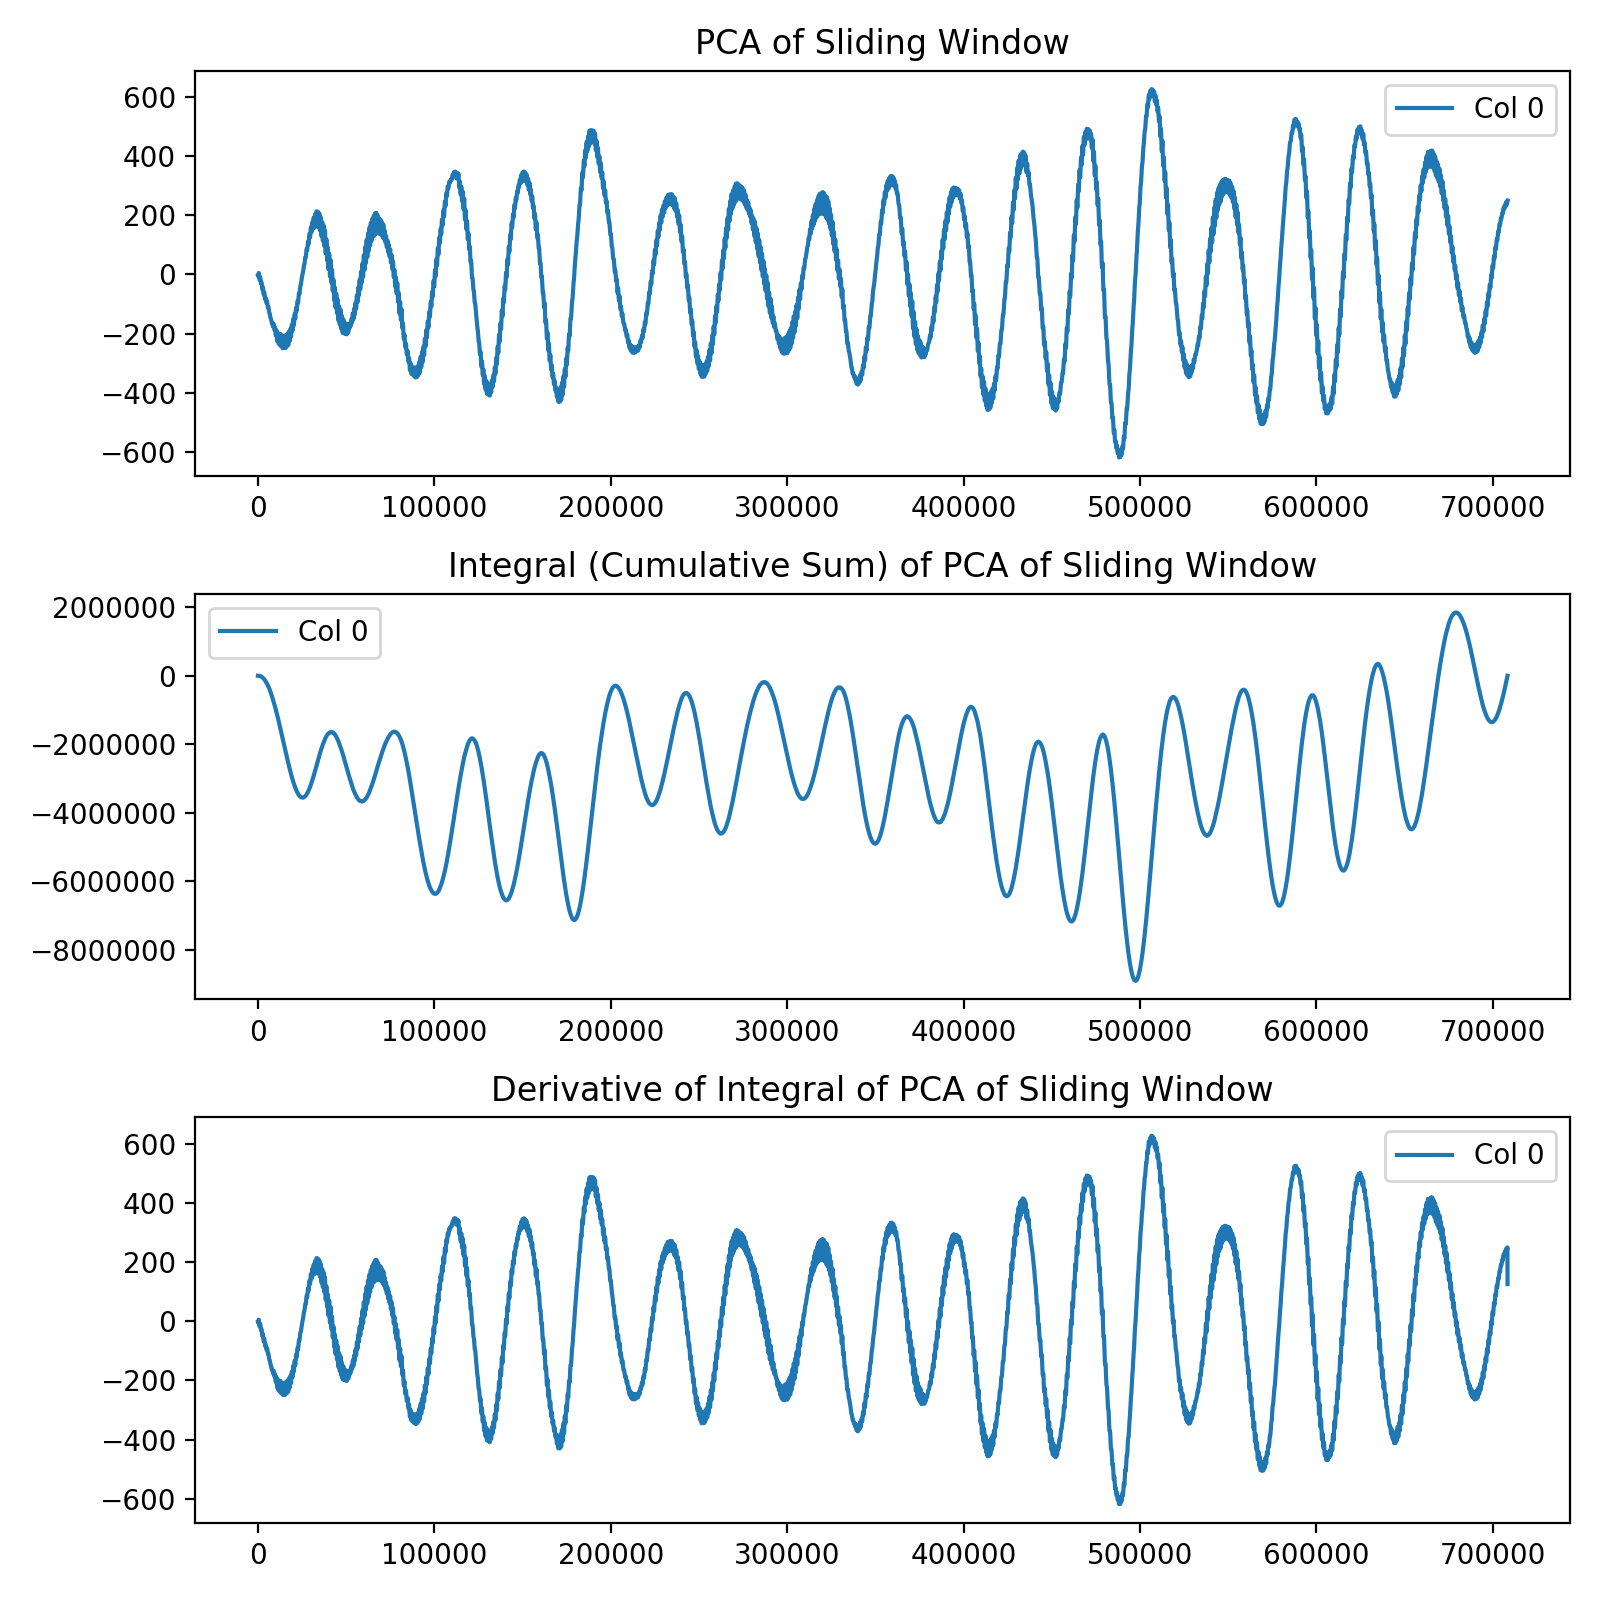

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  


In [6]:
plt.figure(figsize=(8, 8))
plt.subplot(311)
plt.plot(Y)
plt.legend(["Col {}".format(i) for i in range(Y.shape[1])])
plt.title("PCA of Sliding Window")
plt.subplot(312)
plt.plot(YInteg)
plt.legend(["Col {}".format(i) for i in range(Y.shape[1])])
plt.title("Integral (Cumulative Sum) of PCA of Sliding Window")
plt.subplot(313)
plt.plot(YIntegDeriv)
plt.legend(["Col {}".format(i) for i in range(Y.shape[1])])
plt.title("Derivative of Integral of PCA of Sliding Window")
plt.tight_layout()

(70830, 1)


<IPython.core.display.Javascript object>


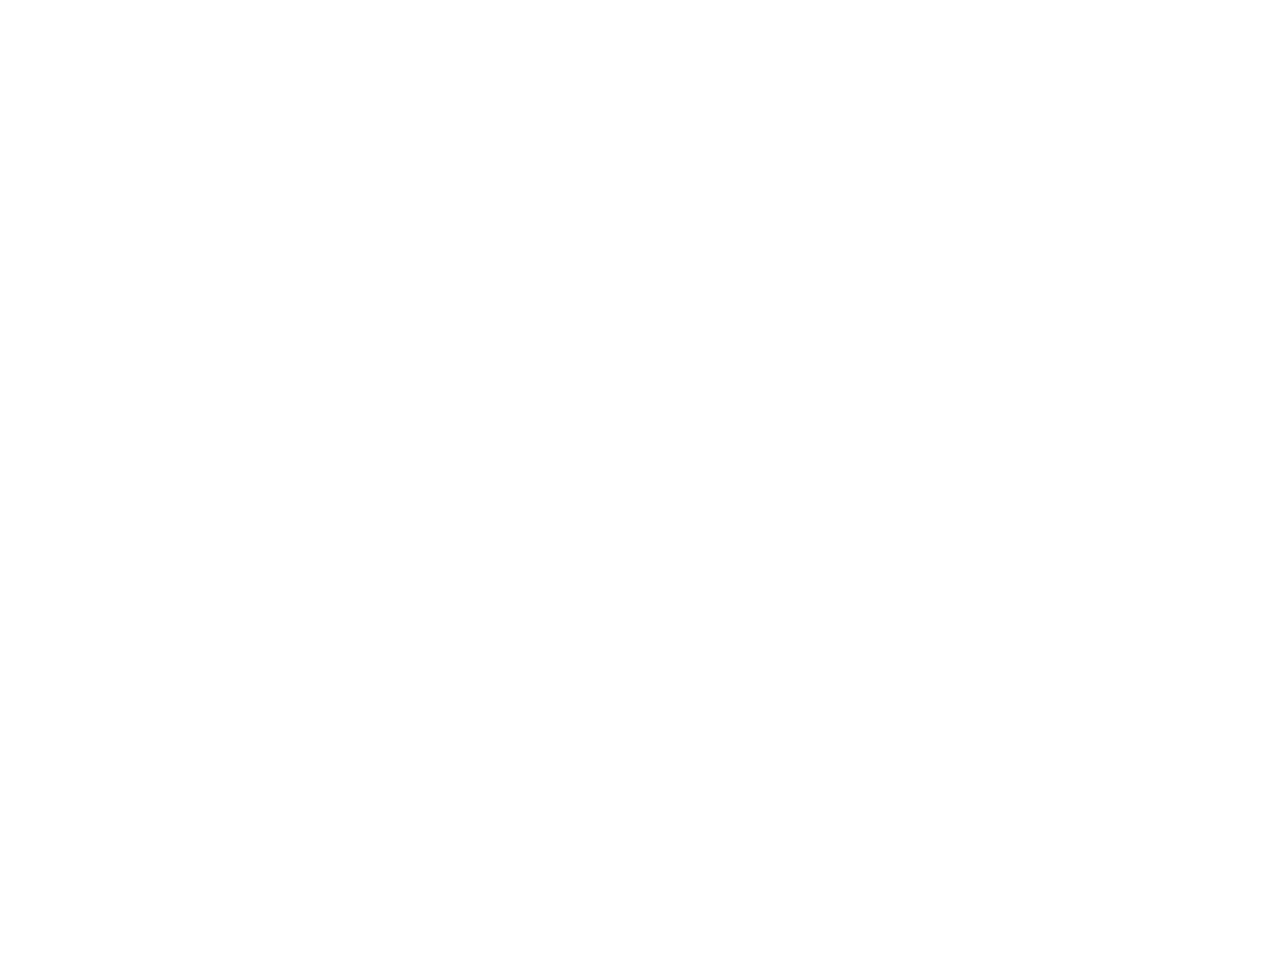

IndexError: index 1 is out of bounds for axis 1 with size 1

In [7]:
Z = Y[0::fac, :]
print(Z.shape)
plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], c=np.arange(Z.shape[0]))
plt.title("2D PCA")
plt.axis('equal')

In [ ]:
# 3D Plot (will be slow to render for B)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=np.arange(Z.shape[0]))

# 6/29 & 6/30 Sunspots Frequency Mod

# $ s(t) = \cos(2 \pi f(t)) $

## Frequency $\nu = f'(t)$ in units of cycles / sec

## Ex) f(t) = kt

## $s(t) = \cos(2 \pi k t)$

In [8]:
fM = np.zeros(len(Y))
Y = apply_freq_mod(Y,freqs)
YInteg = np.cumsum(Y, axis=0)/fs

B = apply_freq_mod(B,freqs)
BInteg = np.cumsum(B, axis=0)/fs
bM = np.cos(2*np.pi*BInteg)

for i in range(len(freqs)-1):
    fM = fM + np.cos(2*np.pi*YInteg[:,i])

In [9]:
ipd.Audio(bM,rate=fs)

How does changing the number of octaves change the sound?

How does changing the number of dimensions change the sound?

What happens when you use the maximum number of dimensions?

How does changing the window length change the sound?  I.e. what happens when you increase or decrease Tau?

Is the pipeline sensitive to that?  

(It would be good if we had some robustness around exact choices to window length.  Then we're already showing an advantage over what they have in the paper)

In [10]:
save_wavfile("BInteg 8 OCtaves into Sinusoid.wav",fs,bM)

-32768
32767
